In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install torchsummary

In [4]:
import torch.nn as nn

class Net_GN(nn.Module):
    def __init__(self):
        super(Net_GN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), bias=False),
            nn.GroupNorm(32, 32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), bias=False),
            nn.GroupNorm(32, 32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(1, 1), bias=False),
            nn.GroupNorm(32, 32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=(3, 3), bias=False),
            nn.GroupNorm(32, 32),
            nn.ReLU(),
            nn.Conv2d(32, 24, kernel_size=(3, 3), bias=False, padding = 1),
            nn.GroupNorm(24,24),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=(3, 3), bias=False, padding = 1),
            nn.GroupNorm(24,24),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=(1, 1), bias=False),
            nn.GroupNorm(24, 24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(24, 24, kernel_size=(3, 3), bias=False, padding = 1),
            nn.GroupNorm(24,24),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=(3, 3), bias=False, padding = 1),
            nn.GroupNorm(24,24),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=(3, 3), bias=False, padding = 1),
            nn.GroupNorm(24,24),
            nn.ReLU(),
            nn.Sequential(nn.AvgPool2d(kernel_size=6)),
            nn.Conv2d(24, 10, kernel_size=(1, 1), bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net_GN().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
         GroupNorm-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           9,216
         GroupNorm-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           1,024
         GroupNorm-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
        MaxPool2d-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           9,216
        GroupNorm-12           [-1, 32, 12, 12]              64
             ReLU-13           [-1, 32, 12, 12]               0
           Conv2d-14           [-1, 24,

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


In [7]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [9]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

dataiter = iter(train_loader)
images, labels = next(dataiter)

Files already downloaded and verified
Files already downloaded and verified


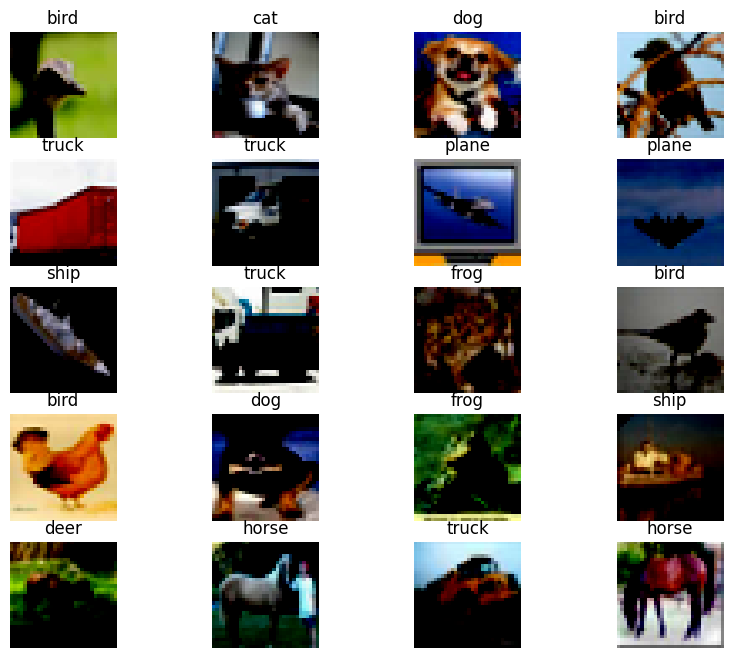

In [10]:
figure = plt.figure(figsize=(10,8))
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(5, 4, index)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1, 2, 0)))
    plt.title(classes[labels[index].item()])


In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.12, momentum=0.90)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Epoch 1


Loss=1.9161908626556396 Batch_id=390 Accuracy=19.46: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]



Test set: Average loss: 1.7969, Accuracy: 3113/10000 (31.13%)

Epoch 2


Loss=1.5239332914352417 Batch_id=390 Accuracy=36.92: 100%|██████████| 391/391 [00:16<00:00, 23.52it/s]



Test set: Average loss: 1.5876, Accuracy: 4182/10000 (41.82%)

Epoch 3


Loss=1.1209036111831665 Batch_id=390 Accuracy=49.92: 100%|██████████| 391/391 [00:16<00:00, 23.38it/s]



Test set: Average loss: 1.2596, Accuracy: 5566/10000 (55.66%)

Epoch 4


Loss=1.1629992723464966 Batch_id=390 Accuracy=58.10: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s]



Test set: Average loss: 1.1912, Accuracy: 5838/10000 (58.38%)

Epoch 5


Loss=1.1010606288909912 Batch_id=390 Accuracy=62.99: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]



Test set: Average loss: 1.0674, Accuracy: 6305/10000 (63.05%)

Epoch 6


Loss=1.0343904495239258 Batch_id=390 Accuracy=66.28: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]



Test set: Average loss: 1.0965, Accuracy: 6145/10000 (61.45%)

Epoch 7


Loss=0.5543638467788696 Batch_id=390 Accuracy=72.52: 100%|██████████| 391/391 [00:16<00:00, 23.35it/s]



Test set: Average loss: 0.8835, Accuracy: 6975/10000 (69.75%)

Epoch 8


Loss=0.5789678692817688 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:17<00:00, 22.33it/s]



Test set: Average loss: 0.8744, Accuracy: 7010/10000 (70.10%)

Epoch 9


Loss=0.6626163721084595 Batch_id=390 Accuracy=75.03: 100%|██████████| 391/391 [00:16<00:00, 23.63it/s]



Test set: Average loss: 0.8721, Accuracy: 7030/10000 (70.30%)

Epoch 10


Loss=0.6266804933547974 Batch_id=390 Accuracy=75.75: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]



Test set: Average loss: 0.8718, Accuracy: 7011/10000 (70.11%)

Epoch 11


Loss=0.7072051763534546 Batch_id=390 Accuracy=76.30: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s]



Test set: Average loss: 0.8718, Accuracy: 7023/10000 (70.23%)

Epoch 12


Loss=0.7258365750312805 Batch_id=390 Accuracy=76.99: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]



Test set: Average loss: 0.8708, Accuracy: 7048/10000 (70.48%)

Epoch 13


Loss=0.6569706797599792 Batch_id=390 Accuracy=78.27: 100%|██████████| 391/391 [00:16<00:00, 23.35it/s]



Test set: Average loss: 0.8625, Accuracy: 7083/10000 (70.83%)

Epoch 14


Loss=0.6888755559921265 Batch_id=390 Accuracy=78.57: 100%|██████████| 391/391 [00:17<00:00, 22.54it/s]



Test set: Average loss: 0.8633, Accuracy: 7061/10000 (70.61%)

Epoch 15


Loss=0.5009607076644897 Batch_id=390 Accuracy=78.73: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s]



Test set: Average loss: 0.8643, Accuracy: 7072/10000 (70.72%)

Epoch 16


Loss=0.5810126066207886 Batch_id=390 Accuracy=78.90: 100%|██████████| 391/391 [00:17<00:00, 23.00it/s]



Test set: Average loss: 0.8642, Accuracy: 7073/10000 (70.73%)

Epoch 17


Loss=0.5866199135780334 Batch_id=390 Accuracy=78.94: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s]



Test set: Average loss: 0.8648, Accuracy: 7077/10000 (70.77%)

Epoch 18


Loss=0.5328692197799683 Batch_id=390 Accuracy=78.98: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s]



Test set: Average loss: 0.8648, Accuracy: 7076/10000 (70.76%)

Epoch 19


Loss=0.7406691908836365 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s]



Test set: Average loss: 0.8647, Accuracy: 7080/10000 (70.80%)

Epoch 20


Loss=0.48518261313438416 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s]



Test set: Average loss: 0.8648, Accuracy: 7080/10000 (70.80%)



Text(0.5, 1.0, 'Test Accuracy')

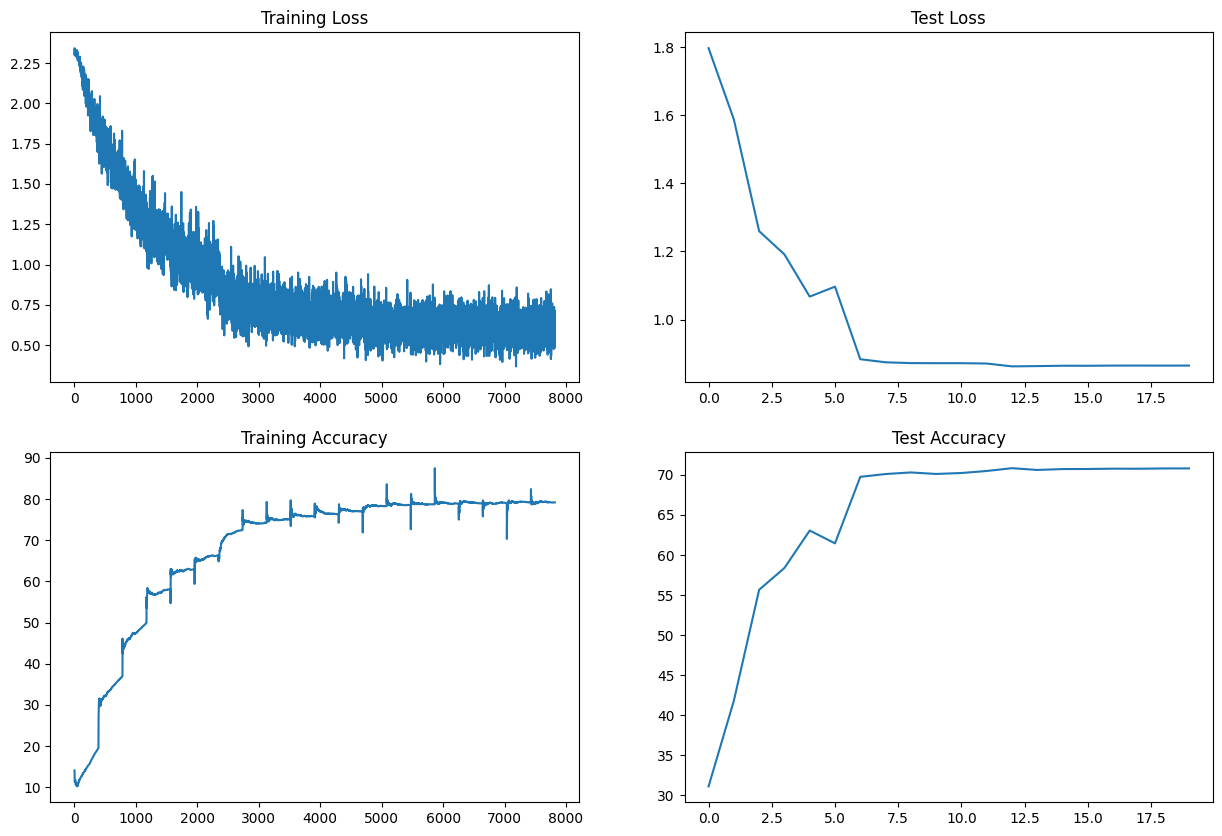

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.tensor(train_losses).cpu().detach().numpy())
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [14]:
error_images = []
error_target = []
error_predicted = []
count = 0

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  for i in range (0, 127):
    if (pred[i].cpu().numpy()[0] != target[i].cpu().numpy()):
      error_images.append(data[i])
      error_target.append(target[i].cpu().numpy())
      error_predicted.append(pred[i].cpu().numpy()[0])

      count = count + 1

      if count > 10:
        break

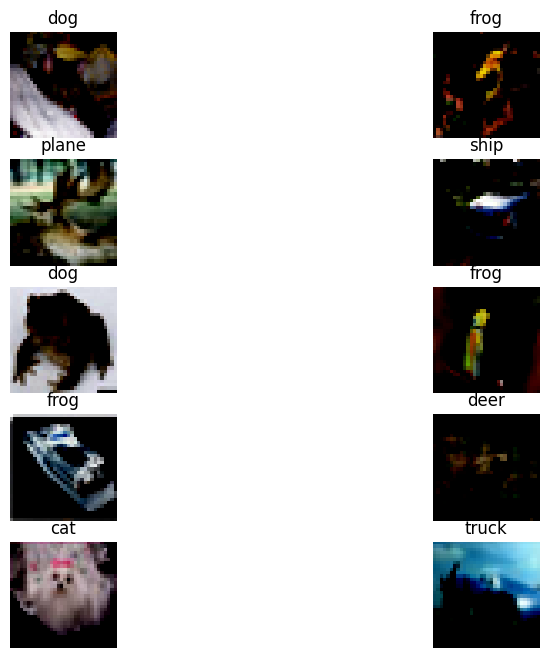

In [15]:
figure = plt.figure(figsize=(10, 8))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.imshow(np.transpose(error_images[index].cpu().numpy(), (1, 2, 0)))
    plt.title(classes[error_predicted[index].item()])
